# Clustering RNA sequences to identify cancer types

In this assignment, we will use clustering algorithms on RNA sequence data to identify cancer types.
Since the [whole data](https://www.synapse.org/#!Synapse:syn4301332) (from [Cancer Genome Atlas Pan-Cancer project](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3919969/)) is very big, we will use a [subset data from UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#). The subset data contains only 5 labels; BRCA, KIRC, COAD, LUAD and PRAD. The meanings of those labels are as below.

|Abbreviation|Cancer|
|:----:|:-------:|
|LUSC|Lung squamous cell carcinoma |
|READ |Rectum adenocarcinoma |
|GBM |Glioblastoma multiforme|
|BLCA |Bladder Urothelial Carcinoma|
|UCEC |Uterine Corpus Endometrioid Carcinoma|
|COAD |Colon adenocarcinoma|
|OV |Ovarian serous cystadenocarcinoma|
|LAML |Acute Myeloid Leukemia|
|HNSC |Head and Neck squamous cell carcinoma|
|LUAD |Lung adenocarcinoma|
|BRCA |Breast invasive carcinoma|
|KIRC |Kidney renal clear cell carcinoma|

Although we can use the data for supervised learning model training, we will not use these labels for training, but use them for evaluation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import time

from sklearn.model_selection import GridSearchCV

In [2]:
# Read data. Do not change the variable names (data, label)
data = pd.read_csv('data/data_m2.csv')
label = pd.read_csv('data/labels_m2.csv')
data=data.drop('Unnamed: 0',axis=1)
label=label.drop('Unnamed: 0',axis=1)

### A. [Peer Review] Perform basic data inspection or EDA on the pandas dataframe.
- How many observations?
- How many features?

In [98]:
# perform basic data inspection such as getting the number of observations and number of features
# you can also display part of the dataframe or run data.info() 
print(f'Observations: {data.shape[0]}, features: {data.shape[1]}')
print(f"Class Labels are: {label['Class'].unique().tolist()}")
print("-"*60)
data.head()


Observations: 801, features: 20531
Class Labels are: ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD']
------------------------------------------------------------


,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What do those numbers mean? (We do not expect students to know or figure out the meanings, but if you do know by chance, feel free to discuss them with the class on the discussion board.) <br>
Answer the Peer Review question about this section. 

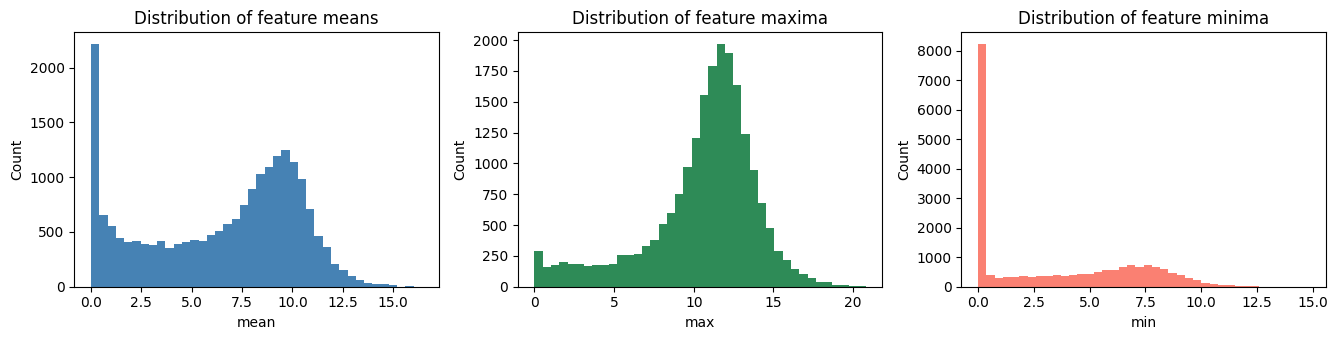

In [17]:
# draw histograms of mean, max and min values in each feature 
plot_data = {}
for col in data.columns:
    plot_data[col] = [data[col].mean(),data[col].max(),data[col].min()]
plot_df = pd.DataFrame(plot_data).T
plot_df.columns = ['mean','max','min']

# Plot histograms of the stats across features
n = 3
fig, axes = plt.subplots(1,n, figsize=(n * 4.5,  3.5))
colours = ['steelblue', 'seagreen', 'salmon']
titles = ['Distribution of feature means', 'Distribution of feature maxima', 'Distribution of feature minima']
for i, col in enumerate(plot_df.columns):
    axes[i].hist(plot_df[col].values, bins=40, color=colours[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].set_title(titles[i])

plt.tight_layout()
plt.show()

- If we were to train a "supervised" learning model, how would you deal with such large feature dimension? 
- Even after feature dimension reduction, still the number of useful features may be enormous. How it would impact performance or runtime of certain supervised learning algorithms? Which algorithms would suffer from high dimension features than others and why? 
- How it would impact performance or runtime of an unsupervised learning algorithm?
- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What those numbers mean? (We do not expect students to know or figure out the meanings, but if you do know by chance, feel free to discuss them with the class on the discussion board.) <br> <br>
Anwer these questions in this week's Peer Review assignment.

## 1. Dealing with Large Feature Dimensions in Supervised Learning

### Dimensionality Reduction Techniques:
- **PCA (Principal Component Analysis)**: Reduces to components explaining most variance
- **Feature Selection**: Statistical tests (chi-square, ANOVA F-test)
- **Domain-specific reduction**: For gene expression data, focus on known biomarkers or differentially expressed genes
- **Feature extraction**: Create new features from combinations of existing ones

### Regularization Methods:
- **L1 (Lasso)**: Drives irrelevant feature coefficients to zero
- **L2 (Ridge)**: Shrinks coefficients but keeps all features
- **Elastic Net**: Combines L1 and L2 penalties

## 2. Impact on Supervised Learning Algorithms

### Algorithms Most Affected by High Dimensions:

**K-Nearest Neighbors (KNN)**:
- **Why suffers**: Distance metrics become less meaningful in high dimensions (curse of dimensionality)
- **Impact**: All points become equidistant, making neighbor selection arbitrary
- **Runtime**: O(nd) for each prediction, where n=samples, d=dimensions

**Naive Bayes**:
- **Why suffers**: Assumes feature independence, which becomes less realistic with many features
- **Impact**: Overconfident predictions, poor calibration

**Decision Trees**:
- **Why suffers**: Prone to overfitting with many features
- **Impact**: Deep trees that don't generalize well
- **Runtime**: Feature selection at each split becomes expensive

### Algorithms More Robust to High Dimensions:

**Support Vector Machines (SVM)**:
- **Why robust**: Works well in high dimensions, especially with RBF kernel
- **But**: Runtime is O(n²) to O(n³), becomes slow with many samples

**Random Forest**:
- **Why robust**: Built-in feature selection through random sampling
- **Advantage**: Can handle irrelevant features naturally

**Linear Models (Logistic Regression with regularization)**:
- **Why robust**: Regularization prevents overfitting
- **Runtime**: Efficient even with many features

**Neural Networks**:
- **Why robust**: Can learn complex feature interactions
- **But**: Need more data and careful regularization

## 3. Impact on Unsupervised Learning

### K-Means Clustering:
- **Suffers severely**: Euclidean distance becomes less meaningful
- **All points become equidistant**: Makes cluster centers arbitrary
- **Solution**: PCA or feature selection before clustering

### Hierarchical Clustering:
- **Similar issues**: Distance-based, suffers from curse of dimensionality
- **Runtime**: O(n³) becomes prohibitive with many features

### DBSCAN:
- **Very sensitive**: Density estimation fails in high dimensions
- **Impact**: Either everything is noise or everything is one cluster

### Algorithms More Robust:
- **Spectral Clustering**: Can work better in high dimensions
- **Gaussian Mixture Models**: With proper regularization

## 4. What the Numbers 0-20 Mean in Gene Expression Data

The values you see (0-20 range) in RNA-seq data typically represent:

### **Log2-transformed expression values**:
- **Raw counts**: Original RNA-seq gives discrete read counts (0, 1, 2, 3, ...)
- **Normalization**: Usually RPKM, FPKM, or TPM normalized
- **Log transformation**: log2(count + 1) to make data more normally distributed
- **Result**: Values typically range from 0-20

### **Biological meaning**:
- **0-1**: Very low or no expression (gene likely "off")
- **5-10**: Moderate expression
- **15-20**: High expression (highly active genes)
- **>20**: Very highly expressed genes (often housekeeping genes)

### **Why this matters for ML**:
- **Scale differences**: Some genes vary 0-2, others 10-20
- **Need scaling**: StandardScaler or robust scaling essential
- **Log scale**: Already somewhat normalized, but still need feature scaling

## Summary for Peer Review:

1. **High dimensions require**: Regularization, feature selection, or dimensionality reduction
2. **Most affected algorithms**: KNN, Naive Bayes, basic Decision Trees
3. **Most robust algorithms**: SVM, Random Forest, regularized linear models
4. **Unsupervised suffers more**: Distance-based methods break down completely
5. **Gene expression values**: Log2-transformed read counts, requiring careful preprocessing

The key insight is that the **curse of dimensionality** affects distance-based algorithms most severely, while regularized methods and ensemble approaches tend to be more robust.

### B. [Peer Review] Build a hierarchical clustering model
Let's build a model using hierarchical clustering. Hierarchical clustering module is available from `sklearn.cluster.AgglomerativeClustering`. You can choose linkage type and metric. Please check its documentation for more details.

**a) Number of clusters vs distance threshold**
Oftentimes hierarchical clustering does not need to know the number of clusters in advance. Instead, one needs to choose threshold distance/similarity to cut the dendrogram later. The AgglomerativeClustering module lets you specify either the number of clusters (n_clusters) or the threshold (distance_threshold). Based on our data, which should we choose to set to which value and why? <br> <br>
Answer this question in the Peer Review assignment. 

#### b) Guess which metric?
Can you guess which metric to use (distance-based vs. similarity-based) and why? 
This question is not graded, but we encourage you to share your thoughts with the class. See the ungraded discussion prompt for this week's material. 

#### c) Build a model
Build a model using n_clusters=5 option. Choose any metric and linkage type at first. Display the clustering result labels (you can just print out the result). Do not change the variable (model) name. Answer the question about this section in the Peer Review.

In [94]:
# build a model using n_clusters=5 option
model=AgglomerativeClustering(n_clusters=5, linkage='complete', metric='euclidean')
start = time.time()
model.fit(data)
end = time.time()
print(f"Agglomerative Clustering took {end-start:.2f} seconds\n")
print(model.labels_)

Agglomerative Clustering took 1.75 seconds

[4 3 1 4 1 4 0 4 1 4 1 0 4 2 1 1 3 0 0 4 1 0 3 1 0 3 2 1 1 1 1 1 0 3 4 1 0
 3 1 3 0 4 4 0 0 1 4 2 1 3 1 3 1 4 2 1 1 3 0 1 3 0 1 3 4 2 1 4 0 1 0 1 1 3
 1 3 1 0 4 2 1 4 1 1 4 4 1 1 0 1 4 4 1 3 1 4 2 1 4 1 1 0 1 0 3 0 3 3 3 3 4
 1 3 4 1 0 0 0 1 1 3 0 3 1 4 4 4 1 0 1 2 1 2 1 1 0 3 1 0 2 1 4 1 0 3 2 4 1
 3 3 3 3 1 1 3 1 1 4 4 3 4 3 0 1 4 3 2 0 3 1 0 3 1 3 1 1 1 4 1 0 2 0 1 4 4
 4 3 3 1 3 3 0 3 4 3 1 3 1 3 3 1 0 0 0 0 4 2 4 1 3 3 1 4 1 4 1 1 1 3 1 0 3
 0 0 3 1 0 4 1 3 3 4 2 2 0 4 0 3 1 0 0 3 4 4 3 3 0 1 1 2 1 4 3 1 4 0 4 4 4
 1 3 2 3 2 3 4 3 1 1 0 0 1 2 4 0 4 1 1 0 1 1 1 2 3 3 1 1 1 0 0 0 0 3 1 1 0
 1 1 3 4 1 1 2 3 4 1 1 1 2 1 4 1 2 3 3 4 0 1 0 0 3 3 0 1 1 1 3 0 1 1 4 3 0
 1 3 4 0 1 4 2 1 1 1 3 3 3 1 1 4 3 1 0 1 2 3 3 1 0 1 1 1 2 3 2 0 4 0 1 1 0
 3 2 4 3 4 3 0 4 1 2 0 0 2 2 4 1 3 3 0 3 4 1 1 1 3 3 0 3 3 0 2 4 1 3 4 1 2
 1 3 1 1 4 1 4 2 1 3 1 1 3 1 1 1 0 3 4 1 4 0 1 0 2 1 4 3 0 1 1 0 1 3 3 1 4
 2 1 0 3 4 1 4 1 1 1 1 0 3 1 0 1 1 3 3 0 3 4 2 1 0 0 1 4

#### d) Label permuation
In clustering, the labels get assigned randomly, so the label numbering won't match the ground truth necessarily. Write a function below to find best matching label ordering based on the accuracy. Do not change the variable names. Answer the question about this section in the Peer Review. 

In [99]:
import itertools

def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    yp = np.asarray(yp, dtype=int)
    y_true = pd.Categorical(ytdf['Class']).codes

    best_perm = tuple(range(n))
    best_acc = -1.0

    for perm in itertools.permutations(range(n),n):
        mapping = np.array(perm, dtype=int)
        mapped = mapping[yp] # i.e. get the indeces of mapping from yp, which changes yp labels to mapped labels
        acc = float((mapped == y_true).mean()) # compare mapped labels to y_true
        if acc > best_acc:
            best_acc = acc
            best_perm = perm
    return best_perm, best_acc

In [82]:
labelorder, acc = label_permute_compare(label, model.labels_)
print(labelorder, acc)

(2, 0, 1, 3, 4) 0.9313358302122348


In [100]:
# Debug your current implementation
def debug_label_permute_compare(ytdf, yp, n=5):
    yp = np.asarray(yp, dtype=int)
    y_true = pd.Categorical(ytdf['Class']).codes

    print(f"Unique cluster labels: {np.unique(yp)}")
    print(f"Unique true labels: {np.unique(y_true)}")
    print(f"yp range: {yp.min()} to {yp.max()}")
    print(f"y_true range: {y_true.min()} to {y_true.max()}")
    print(f"n parameter: {n}")
    print(f"yp shape: {yp.shape}, y_true shape: {y_true.shape}")

    # Check a simple identity mapping first
    identity_acc = (yp == y_true).mean()
    print(f"Identity mapping accuracy: {identity_acc:.4f}")

    return label_permute_compare(ytdf, yp, n)

# Test it
labelorder, acc = debug_label_permute_compare(label, model.labels_)
print(f"Best permutation: {labelorder}, Best accuracy: {acc:.4f}")

Unique cluster labels: [0 1 2 3 4]
Unique true labels: [0 1 2 3 4]
yp range: 0 to 4
y_true range: 0 to 4
n parameter: 5
yp shape: (801,), y_true shape: (801,)
Identity mapping accuracy: 0.3421
Best permutation: (2, 0, 1, 3, 4), Best accuracy: 0.9313


#### e) Check confusion matrix
Use sklearn's confusion matrix and display the results. Answer the Peer Review question about this section.  

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay
# Build mapping: cluster index (from model.labels_) -> class name

def build_class_mapping(label, model, verbose = True):
    cat = pd.Categorical(label['Class'])
    class_names = list(cat.categories)
    labelorder, acc = label_permute_compare(label, model.labels_)# names aligned with codes used in label_permute_compare
    cluster_to_class = {cluster: class_names[code] for cluster, code in enumerate(labelorder)}

    y_pred_names = np.array([cluster_to_class[k] for k in model.labels_])
    model_type = type(model).__name__
    param_dict = model.get_params()
    if model_type == 'AgglomerativeClustering':
        title_text = f'Agglomerative Clustering (linkage: {param_dict["linkage"]}, metric: {param_dict["metric"]})'
    elif model_type == 'KMeans':
        title_text = f'KMeans (n_clusters: {param_dict["n_clusters"]})'
    else:
        title_text = model_type

    if verbose == True:
        print("Cluster -> Class mapping:")
        for k, v in cluster_to_class.items():
            print(f"{k} -> {v}")
        cm = confusion_matrix(label, y_pred_names)
        disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp_cm.plot(cmap='Blues')
        disp_cm.ax_.set_title(f'Confusion Matrix for {title_text}, \nAccuracy: {acc:.4f}')
        plt.show()

    return cluster_to_class, y_pred_names, acc

Cluster -> Class mapping:
0 -> KIRC
1 -> BRCA
2 -> COAD
3 -> LUAD
4 -> PRAD


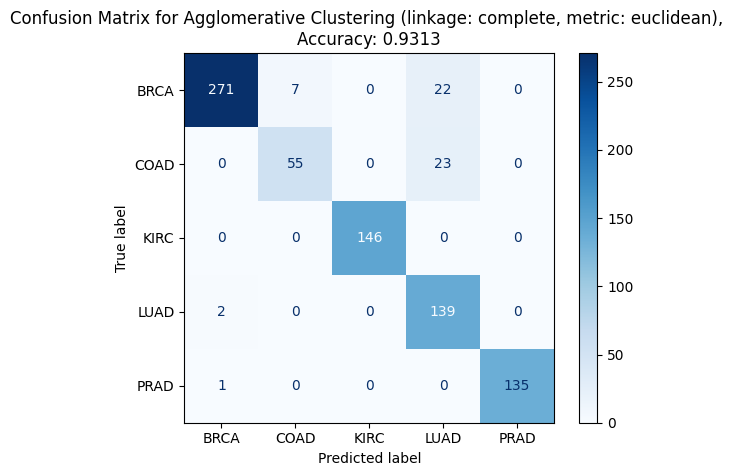

In [87]:
cluster_to_class, y_pred_names, acc = build_class_mapping(label, model, verbose = True)

#### f) Change linkage method and distance metric. Which ones lead the best performance? Print out the accuracy and confusion matrix for the best model.
<br> Answer the Peer Review questions about this section. 

Linkage: ward     | Metric: euclidean | Accuracy: 0.9950
Linkage: complete | Metric: euclidean | Accuracy: 0.9313
Linkage: complete | Metric: manhattan | Accuracy: 0.7228
Linkage: complete | Metric: cosine    | Accuracy: 0.7403
Linkage: average  | Metric: euclidean | Accuracy: 0.3645
Linkage: average  | Metric: manhattan | Accuracy: 0.3658
Linkage: average  | Metric: cosine    | Accuracy: 0.3645
Linkage: single   | Metric: euclidean | Accuracy: 0.3758
Linkage: single   | Metric: manhattan | Accuracy: 0.3745
Linkage: single   | Metric: cosine    | Accuracy: 0.3758
------------------------------------------------------------
Best combination: {'linkage': 'ward', 'metric': 'euclidean'}
Best accuracy: 0.9950
------------------------------------------------------------
Cluster -> Class mapping:
0 -> BRCA
1 -> KIRC
2 -> PRAD
3 -> LUAD
4 -> COAD


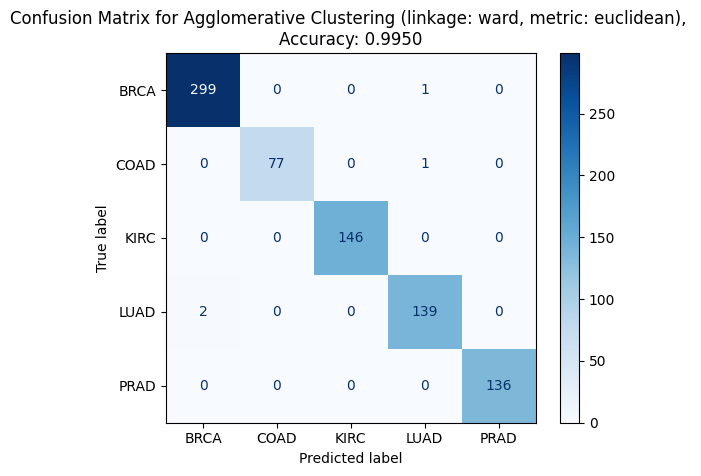

In [88]:
# programmatically evaluate which linkage method and distance metric lead to the best performance
param_grid = [
    # Ward only works with euclidean
    {'linkage': ['ward'], 'metric': ['euclidean']},
    # Other linkages with various metrics
    {'linkage': ['complete', 'average', 'single'],
     'metric': ['euclidean', 'manhattan', 'cosine']}
]
results = []
best_score = -1.0
best_params = None
best_model = None

for param_dict in param_grid:
    keys = param_dict.keys()
    values = param_dict.values()

    # Generate all combinations
    for combination in itertools.product(*values):
        params = dict(zip(keys, combination))

        try:
            # Create and fit model
            model = AgglomerativeClustering(n_clusters=5, **params)
            cluster_labels = model.fit_predict(data)

            _, acc = label_permute_compare(label, cluster_labels)

            results.append({
                'linkage': params['linkage'],
                'metric': params['metric'],
                'accuracy': acc
            })

            print(f"Linkage: {params['linkage']:8s} | Metric: {params['metric']:9s} | Accuracy: {acc:.4f}")

            # Track best model
            if acc > best_score:
                best_score = acc
                best_params = params
                best_model = model

        except Exception as e:
            print(f"Error with {params}: {e}")

print("-" * 60)
print(f"Best combination: {best_params}")
print(f"Best accuracy: {best_score:.4f}")
print("-" * 60)
cluster_to_class, y_pred_names, acc = build_class_mapping(label, best_model, verbose = True)

**Ward linkage** is a method for measuring the distance between clusters in agglomerative clustering. Here's how to understand it:

## What Ward Linkage Does
Ward linkage minimizes the **within-cluster sum of squares** (WCSS) when merging clusters. It asks: "Which two clusters, when merged, will increase the total variance within clusters the least?"

## How It Works
1. **Start**: Each point is its own cluster
2. **At each step**: Consider all possible pairs of clusters to merge
3. **Merge criterion**: Choose the pair that results in the smallest increase in total within-cluster variance
4. **Continue**: Until you have the desired number of clusters

## Mathematical Intuition
- **Within-cluster variance** = sum of squared distances from each point to its cluster centroid
- Ward linkage tries to keep clusters "compact" by minimizing this variance
- This tends to create clusters that are roughly spherical and similar in size

## Why Only Euclidean Distance?
Ward linkage requires Euclidean distance because:
- It needs to calculate centroids (cluster centers)
- The variance calculation depends on squared Euclidean distances
- Other distance metrics (Manhattan, cosine) don't have the geometric properties needed for the variance calculation

## Comparison with Other Linkages
- **Complete**: Merges clusters with smallest maximum distance between any two points
- **Average**: Merges clusters with smallest average distance between all point pairs
- **Single**: Merges clusters with smallest minimum distance between any two points
- **Ward**: Merges clusters that minimize increase in within-cluster variance

## When to Use Ward
- **Good for**: Creating compact, roughly equal-sized clusters
- **Works well**: When clusters are expected to be spherical/round
- **Not ideal**: For elongated clusters or when clusters have very different sizes
- **Best with**: Standardized/normalized features (since it uses Euclidean distance)

## Practical Example
If you have customer data and want to segment customers into groups, Ward linkage would try to create segments where customers within each segment are as similar as possible to each other (low variance), while being different from other segments.

Ward is often a good default choice for agglomerative clustering because it tends to produce well-balanced, interpretable clusters.

### C. What about k-means clustering?
Can we apply kmeans clustering on this data? Which clustering methods give a better performance? Is kmeans faster or slower?

Kmeans took 0.19 seconds
Cluster -> Class mapping:
0 -> BRCA
1 -> PRAD
2 -> COAD
3 -> LUAD
4 -> KIRC


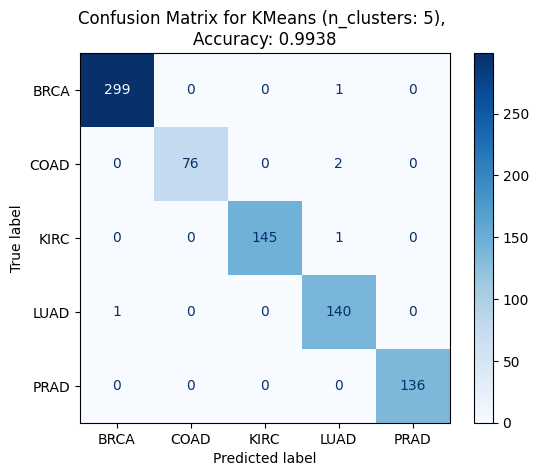

In [89]:
# try to apply kmeans clustering on this data
# time kmeans to compare to hierarchical clustering 
model_kmeans = KMeans(n_clusters=5)
start = time.time()
model_kmeans.fit(data)
end = time.time()
print(f"Kmeans took {end-start:.2f} seconds")
cluster_to_class, y_pred_names, acc = build_class_mapping(label, model_kmeans, verbose = True)


## Trying to improve KMeans Clustering
- **Scaling**: Prevents features with larger ranges from dominating
- **PCA**: Removes noise and focuses on main patterns
- **Better params**: More stable convergence and better local minima avoidance


KMeans time: 0.28 seconds
Cluster -> Class mapping:
0 -> BRCA
1 -> KIRC
2 -> LUAD
3 -> PRAD
4 -> COAD


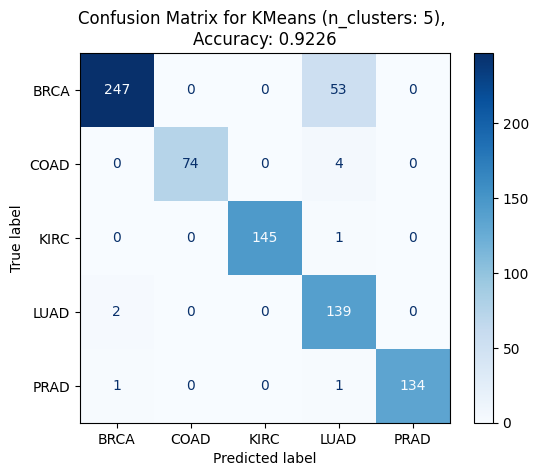

In [91]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Step 2: Dimensionality reduction (optional but recommended)
pca = PCA(n_components=100, random_state=42)
data_pca = pca.fit_transform(data_scaled)

# Step 3: KMeans with better parameters
model_kmeans_pca = KMeans(
    n_clusters=5,
    init='k-means++',
    n_init=20,
    max_iter=500,
    random_state=42
)

start_time = time.time()
model_kmeans_pca.fit(data_pca)
kmeans_time = time.time() - start_time

# Evaluate
print(f"KMeans time: {kmeans_time:.2f} seconds")
cluster_to_class, y_pred_names, acc = build_class_mapping(label, model_kmeans_pca, verbose = True)